# ***Netflix Challenge Prediction - Demo Test***

In [7]:
from MoviePredictor import MoviePredictor
import pandas as pd
import numpy as np

### **Função de Escolha de Índices e Predição**

In [8]:
def predict(data, quantity=1000, ignored_value=None, n_of_eigval=30):
    '''
    Aproxima o score que um usuário dá para algum filme da Netflix.
    O processo é feito através da decomposição SVD da matriz de dados, que substitui valores por ruído.

    Parâmetros
    ----------
    data : numpy.ndarray
        Matriz de dados com os scores dos usuários para os filmes.
    quantity : int, optional
        Quantidade de scores que serão transforamdos em ruído e então preditos. O padrão é 1000.
    ignored_value : int, optional
        Valor que será ignorado na hora de selecionar os scores que serão preditos. O padrão é None.
        Normalmente é o valor usado como fill_value na criação da tabela de dados, já que apenas queremos considerar
        valores realmente observados.
    n_of_eigval : int, optional
        Quantidade de autovalores que serão utilizados na predição. O padrão é 30.
    
    Retorno
    -------
    numpy.ndarray
        Array com os erros, ou seja, scores reais menos os scores preditos.
    '''
    indexes = []
    real_score = []

    if ignored_value is not None:
        while len(indexes) < quantity:
            # encontra um índice aleatório que não seja o valor ignorado e que ainda não tenha sido selecionado
            i = np.random.randint(0, data.shape[0])
            j = np.random.randint(0, data.shape[1])

            if data[i][j] != ignored_value and (i, j) not in indexes:
                indexes.append((i, j))
                real_score.append(data[i][j])
                # coloca ruído na matriz de dados
                data[i][j] = np.random.randint(0, 5)
         
    else:
        while len(indexes) < quantity:
            i = np.random.randint(0, data.shape[0])
            j = np.random.randint(0, data.shape[1])

            if (i, j) not in indexes:
                indexes.append((i, j))
                real_score.append(data[i][j])
                # coloca ruído na matriz de dados
                data[i][j] = np.random.randint(0, 5)
    
    # cria o preditor baseado nos dados "sujos" e no número de autovalores que devem ser selecionados
    mp = MoviePredictor(data, n_of_eigval)
    
    # faz a predição
    predicted_score = mp.predict(indexes)
    real_score = np.array(real_score)

    # retorna os erros
    return real_score - predicted_score

## **Descobrindo o Número de Autovalores Ideal**

A primeira anáise foi visual, considerando o gráfico dos autovalores e escolhendo 30 como a margem onde eles se tornam pequenos demais.

![imagem](s.png)

Para uma escolha mais exata, realizamos 1000 substituições para quantidades diferentes de autovalores e analisando e menor erro absoluto médio.

In [9]:
# Número de autovalores a considerar
n_of_eigval = 10

df = pd.read_csv('ratings_small.csv')

data = pd.pivot_table(df, values='rating', index='userId', columns='movieId', fill_value=np.mean(df['rating']))

data = data.to_numpy()

df_errors = pd.DataFrame(columns=['Number of eigenvalues', 'Mean absolute error'])

# faz 10 predições com quantidade de autovalores diferentes para encontrar o mais eficiente, ou seja
# com menor erro absoluto médio
for _ in range(10):
    e = predict(data, 1000, np.mean(df['rating']), n_of_eigval)

    append = pd.DataFrame({"Number of eigenvalues":[n_of_eigval], "Mean absolute error": [np.mean(np.abs(e))]})
    df_errors.loc[len(df_errors)] = append.iloc[0]

    n_of_eigval += 10

df_errors.to_csv('find-best-eigenvalues.csv', index=False)

In [10]:
# Encontra o menor erro absoluto médio e o número de autovalores que o gerou
df_errors = pd.read_csv('find-best-eigenvalues.csv')
best = df_errors.loc[df_errors['Mean absolute error'].idxmin()]

print(f'Best number of eigenvalues: {best["Number of eigenvalues"]}')
print(f'Minimum mean absolute error: {best["Mean absolute error"]}')

Best number of eigenvalues: 10.0
Minimum mean absolute error: 0.8497855339514907


In [11]:
df_errors.head(10)

,Number of eigenvalues,Mean absolute error
0,10.0,0.849786
1,20.0,0.966713
2,30.0,0.992105
3,40.0,1.109558
4,50.0,1.171893
5,60.0,1.199032
6,70.0,1.215597
7,80.0,1.302625
8,90.0,1.387824
9,100.0,1.382673


## **Testes Iniciais**

Com números diferentes de substituições e iterações

### **Teste (1)** - 1000 substituições 1 vez

Substituição de 1000 valores simultâneos por ruído, e então análise da distribuição dos erros

In [12]:
df = pd.read_csv('ratings_small.csv')

# Gera a tabela de dados com rows sendo os usuários e columns sendo os filmes, e cada valor é o rating dado
data = pd.pivot_table(df, values='rating', index='userId', columns='movieId', fill_value=np.mean(df['rating']))

# Transforma a tabela de dados em um array numpy
data = data.to_numpy()

In [13]:
# Como o fill_value foi a média dos ratings válidos, o valor ignorado é esse, já que queremos considerar apenas
# observações reais dos dados
errors = predict(data, 1000, np.mean(df['rating']), n_of_eigval=10)

In [14]:
print(errors)

[-3.82051365e-01  4.52404120e-01 -1.29289839e+00  4.06928243e-01
  2.77366203e-01  1.29915671e+00  5.25402144e-01  3.44835214e-01
 -5.46354390e-01  4.01731974e-01  1.39187713e+00  4.91111525e-01
 -5.72955880e-01 -2.77390389e-02  4.62443458e-01 -1.48741488e-01
 -5.38717079e-01  1.03708681e+00 -4.87704590e-02  4.40493752e-01
 -7.60414393e-02  8.09144986e-01  1.45770786e+00  6.58091256e-01
  5.28125362e-01 -5.52570181e-02  1.37368401e+00 -5.04697930e-01
 -3.62877968e-01  4.23323409e-01  2.88993025e+00 -1.20341590e-01
  2.91472327e+00 -1.72494258e-01 -4.68360466e-01  5.22663335e-01
 -3.47528689e-02 -1.23178929e+00  4.93841866e-01  4.57167725e-01
 -5.43101776e-01  3.27072576e+00 -5.01628169e-02 -4.95650720e-01
 -5.18642945e-01  3.89336899e+00  9.61013667e-01 -8.72146188e-01
 -5.28356311e-01  1.45766787e+00 -4.81905780e-01 -5.63835212e-01
  4.50344500e-01 -3.66764390e-01 -6.19879727e-01  4.41337529e-01
 -1.52162728e+00 -2.13411528e+00  3.66159464e-01  4.04446079e-01
  9.34238219e-01  4.37611

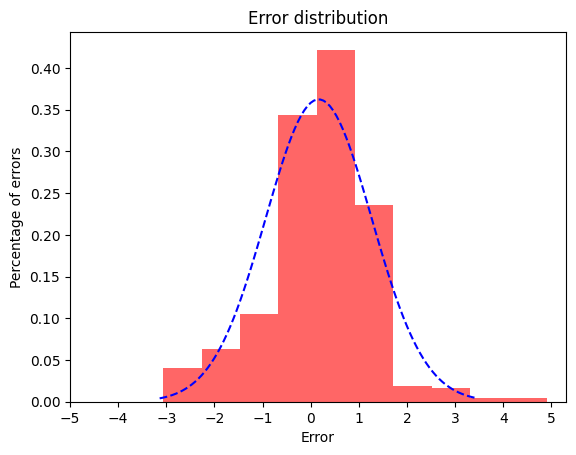

In [15]:
import matplotlib.pyplot as plt


plt.figure()

# Código da curva normal gerado com auxilio do ChatGPT
mu, sigma = np.mean(errors), np.std(errors)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

plt.plot(x, y, 'b--')


plt.hist(errors, bins=10, density=True, alpha=0.6, color='r')
plt.xticks(np.arange (-5, 5.1, 1))
plt.xlabel('Error')
plt.ylabel('Percentage of errors')
plt.title('Error distribution')
plt.show()

In [16]:
# Calcula o erro absoluto médio
mae = np.mean(np.abs(errors))

print(f'Mean absolute error: {mae}')


# Calcula o desvio padrão dos erros
std = np.std(errors)

print(f'Standard deviation of the errors: {std}')

Mean absolute error: 0.855665470393587
Standard deviation of the errors: 1.1012803287772734


### **Teste (2)** - 100 substituições realizadas 10 vezes

Repete o processo de 100 predições 10 vezes e analisa a distribuição de erros, além de salvar o erro absoluto médio de cada iteração.

In [17]:
df = pd.read_csv('ratings_small.csv')

data = pd.pivot_table(df, values='rating', index='userId', columns='movieId', fill_value=np.mean(df['rating']))

data = data.to_numpy()

In [18]:
errors = np.array([])

df_100_tests = pd.DataFrame(columns=['Number of Test', 'Mean absolute error'])

# Para cada teste, faz 100 predições ao mesmo tempo e calcula o erro absoluto médio, que poderá ser analisado no csv
# Além disso, salva todos os erros para serem analisados no histograma posteriormente
for i in range(10):
    # Concatenate 2 numpy arrays
    errors = np.concatenate((errors, predict(data, 100, np.mean(df['rating']), n_of_eigval=10)))

    append = pd.DataFrame({"Number of Test":[i], "Mean absolute error": [np.mean(np.abs(errors))]})
    df_100_tests.loc[len(df_100_tests)] = append.iloc[0]

df_100_tests.to_csv('100-tests.csv', index=False)

In [19]:
print(errors)

[ 8.57141654e-01 -5.49131904e-01  8.98689109e-01 -2.41196222e+00
  3.55636802e-01 -5.33273354e-01  6.94584910e-02 -5.87741324e-01
  4.67950856e-01  3.86724175e-01  2.44727910e+00  1.13269211e+00
  2.95656020e-01  1.30412807e+00 -5.40371131e-02 -3.74284988e-01
  7.96046501e-01 -5.25218598e-01 -7.90184537e-01  2.92301671e+00
  3.91292808e+00 -8.88127775e-01 -5.98433210e-01 -1.51944961e+00
  1.44692911e+00  9.68444416e-01  9.48559037e-01  1.40570280e-02
  4.54452241e-01 -2.52518284e+00 -5.13309565e-01  1.40997309e+00
  1.68783030e+00 -1.47443472e+00  8.23133292e-02  5.10362978e-01
 -5.75035851e-01  3.89838345e-02 -2.46600307e-02 -6.19020588e-01
 -3.85076867e-01  4.50501224e-01  3.61998786e-01 -8.59741148e-01
  3.61343903e-01  1.45814706e+00  1.40563189e+00  3.19528658e-01
  1.46877494e+00 -2.00408563e+00 -1.07773050e-01 -4.30110116e-01
  1.45610550e+00  9.41705347e-01 -2.34520579e+00  2.02192608e-01
  1.27372442e-01  6.68867442e-01 -5.42167932e-01 -4.77771109e-01
 -5.42611089e-01  4.30105

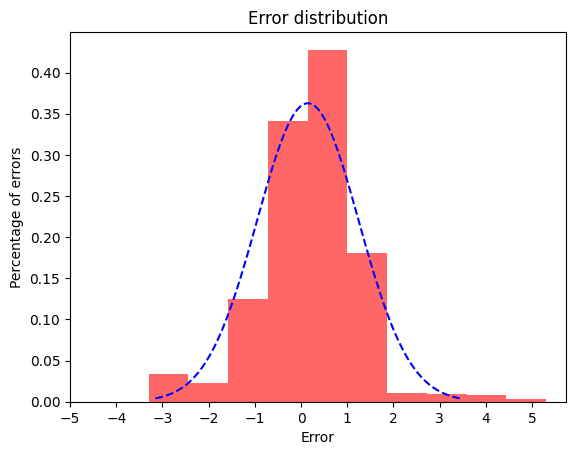

In [20]:
import matplotlib.pyplot as plt


plt.figure()

# Código da curva normal gerado com auxilio do ChatGPT
mu, sigma = np.mean(errors), np.std(errors)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

plt.plot(x, y, 'b--')


plt.hist(errors, bins=10, density=True, alpha=0.6, color='r')
plt.xticks(np.arange (-5, 5.1, 1))
plt.xlabel('Error')
plt.ylabel('Percentage of errors')
plt.title('Error distribution')
plt.show()

In [21]:
# Calcula o erro absoluto médio
mae = np.mean(np.abs(errors))

print(f'Mean absolute error: {mae}')


# Calcula o desvio padrão dos erros
std = np.std(errors)

print(f'Standard deviation of the errors: {std}')

Mean absolute error: 0.842224701088835
Standard deviation of the errors: 1.0998116832025817


### **Teste (3)** - 10 substituições realizadas 100 vezes

Repete o processo de 10 predições 100 vezes e analisa a distribuição de erros, além de salvar o erro absoluto médio de cada iteração.

In [34]:
df = pd.read_csv('ratings_small.csv')

data = pd.pivot_table(df, values='rating', index='userId', columns='movieId', fill_value=np.mean(df['rating']))

data = data.to_numpy()

In [35]:
errors = np.array([])

df_1000_tests = pd.DataFrame(columns=['Number of Test', 'Mean absolute error'])

# Para cada teste, faz 10 predições ao mesmo tempo (100 vezes) e calcula o erro absoluto médio, que poderá ser analisado no csv
# Além disso, salva todos os erros para serem analisados no histograma posteriormente
for i in range(100):
    # Concatenate 2 numpy arrays
    errors = np.concatenate((errors, predict(data, 10, np.mean(df['rating']), n_of_eigval=10)))

    append = pd.DataFrame({"Number of Test":[i], "Mean absolute error": [np.mean(np.abs(errors))]})
    df_1000_tests.loc[len(df_1000_tests)] = append.iloc[0]

df_1000_tests.to_csv('1000-tests.csv', index=False)

In [36]:
print(errors)

[ 1.71418023e+00  6.27451442e-01  8.23087709e-01  1.34726215e+00
  6.13656655e-01  7.11816721e-01  2.15126299e-01 -5.22130119e-01
  3.01110826e+00  2.97278057e+00 -5.15594610e-01  4.96424813e-01
 -5.05961164e-01 -2.98665997e+00  4.75740685e-01  6.95624065e-01
 -6.07171006e-01  1.19341254e-01  1.47462623e+00 -4.92691708e-01
  4.47403173e-01  1.44663104e+00 -5.56509113e-01  7.67897440e-01
  1.04488359e+00  4.16103200e+00  2.24764672e+00  4.61636972e-01
 -3.63990405e-01  1.30192258e+00  4.23791454e-01 -2.86991404e+00
  1.47240199e+00 -6.41370532e-02  1.00715209e+00  3.32817764e-02
  3.98069543e-01 -6.67520093e-01  5.38803017e-01 -5.36325359e-01
 -1.43948466e+00  1.98572020e+00 -1.73591126e-01 -5.33211671e-01
  4.85727348e-01 -2.38278279e-01  4.79427446e-01  4.36257176e-01
  1.44519695e+00  6.36416165e-01  4.51140321e-01 -9.94776545e-01
  5.32724873e-01  4.43466126e-01  5.93056684e-01  1.99122716e-01
  9.27590401e-01  5.14194909e-01  4.56264480e-01  5.09098613e+00
  1.50930389e+00 -3.52664

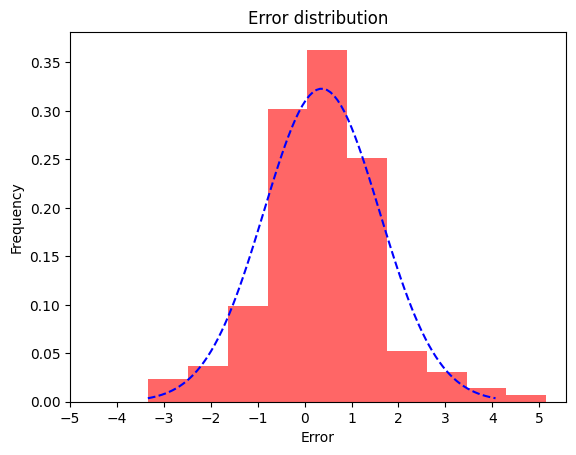

In [37]:
import matplotlib.pyplot as plt


plt.figure()

# Código da curva normal gerado com auxilio do ChatGPT
mu, sigma = np.mean(errors), np.std(errors)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

plt.plot(x, y, 'b--')


plt.hist(errors, bins=10, density=True, alpha=0.6, color='r')
plt.xticks(np.arange (-5, 5.1, 1))
plt.xlabel('Error')
plt.ylabel('Percentage of errors')
plt.title('Error distribution')
plt.show()

In [38]:
# Calcula o erro absoluto médio
mae = np.mean(np.abs(errors))

print(f'Mean absolute error: {mae}')


# Calcula o desvio padrão dos erros
std = np.std(errors)

print(f'Standard deviation of the errors: {std}')

Mean absolute error: 0.9662062630537643
Standard deviation of the errors: 1.235156665491315


### **Teste FINAL** - 1 substituição realizadas 1000 vezes

Repete o processo de 1 predições 1000 vezes e analisa a distribuição de erros.

*OBS: como é um erro por vez, pudemos não salvar no csv o erro absoluto médio, e sim o próprio erro*

In [ ]:
df = pd.read_csv('ratings_small.csv')

data = pd.pivot_table(df, values='rating', index='userId', columns='movieId', fill_value=np.mean(df['rating']))

data = data.to_numpy()

In [ ]:
df_individual_tests = pd.DataFrame(columns=['Number of Test', 'Error'])

# Para cada teste, faz 1 predição e salva o erro para ser analisado no histograma posteriormente
# OBS: esse teste, por ser muito longo, foi realizado em uma máquina na nuvem com 16 cores de processamento
#      e então apenas o csv gerado é carregado para o notebook
for i in range(1000):

    append = pd.DataFrame({"Number of Test":[i], "Error": [predict(data, 1, np.mean(df['rating']), n_of_eigval=10)]})
    df_individual_tests.loc[len(df_individual_tests)] = append.iloc[0]

df_individual_tests.to_csv('individual-tests.csv', index=False)

C:\Users\neodr\AppData\Local\Temp\ipykernel_1528\4171349223.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_individual_tests['Error'] = df_individual_tests['Error'].str.replace('[','').str.replace(']','').astype(float)


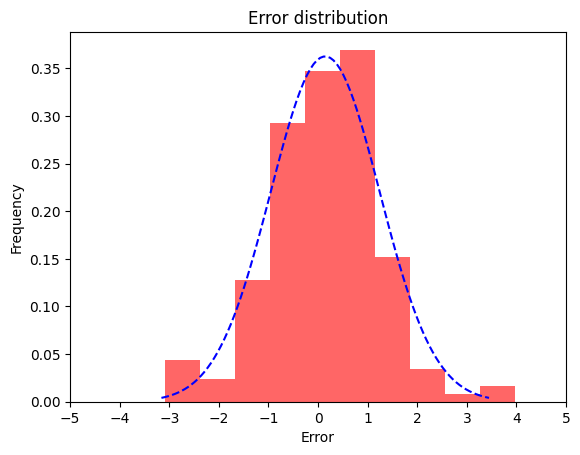

In [22]:
import matplotlib.pyplot as plt

# Abre o csv gerado no teste anterior
df_individual_tests = pd.read_csv('individual-tests.csv')
# Salvei sem querer os erros como listas, então é preciso tirar os colchetes
df_individual_tests['Error'] = df_individual_tests['Error'].str.replace('[','').str.replace(']','').astype(float)

plt.figure()

# Código da curva normal gerado com auxilio do ChatGPT
mu, sigma = np.mean(df_individual_tests['Error']), np.std(df_individual_tests['Error'])

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x - mu)**2/(2*sigma**2))

plt.plot(x, y, 'b--')


plt.hist(df_individual_tests['Error'], bins=10, density=True, alpha=0.6, color='r')
plt.xticks(np.arange (-5, 5.1, 1))
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error distribution')
plt.show()

In [23]:
# Calcula o erro absoluto médio
mae = np.mean(np.abs(df_individual_tests['Error']))

print(f'Mean absolute error: {mae}')


# Calcula o desvio padrão dos erros
std = np.std(df_individual_tests['Error'])

print(f'Standard deviation of the errors: {std}')

Mean absolute error: 0.8570620029712793
Standard deviation of the errors: 1.1007180289497658


# **Teste de Estresse**

O erro absoluto máximo aceitável é de 2.5. O código roda testes, inserindo cada vez mais ruído nos *ratings*, até superar essa marca.

No entanto, observamos que o erro absoluto médio diminui com mais ruído. Mais informações no `README.md`

In [24]:
def stress_predict(data, indexes, K:int):
    '''
    Função adaptada de predição, mas agora considera que apenas recebe posições de ratings válidos
    na matriz de dados, e a quantidade deles que deve ser transformada em ruído. 
    Então, faz a predição, retornando o erro

    Parâmetros:
    data: matriz de dados
    indexes: lista de tuplas com as posições dos ratings válidos
    K: quantidade de ratings válidos que serão transformados em ruído

    Retorno:
    real_score - predicted_score: vetor com os erros
    '''
    real_score = []

    for i, j in indexes[0:K]:
        real_score.append(data[i][j])
        # Coloca um valor aleatório entre 0 e 5 no lugar do rating
        data[i][j] = np.random.randint(0, 5)
    
    mp = MoviePredictor(data, 10)

    predicted_score = mp.predict(indexes[0:K])
    real_score = np.array(real_score)

    return real_score - predicted_score

Separa todos os índices válidos na tabela

In [25]:
# Gera uma lista de tuplas com as posições dos ratings válidos

df = pd.read_csv('ratings_small.csv')
pv = pd.pivot_table(df, values='rating', index='userId', columns='movieId')

indexes = []
for i in range(pv.shape[0]):
    for j in range(pv.shape[1]):
        if pd.notna(pv.iloc[i, j]):
            indexes.append((i, j))

A cada iteração, aumenta em 5000 o número de ruídos na tabela

In [26]:
df_ = pd.DataFrame(columns=["Noise", "Mean absolute error"])

indexes = np.array(indexes)
# Começa com 5000 ratings válidos transformados em ruído e vai aumentando de 5000 em 5000 até 100000
n = 5000
mae = 0 # Erro absoluto médio
while n <= 100000:
    data = pd.pivot_table(df, values='rating', index='userId', columns='movieId', fill_value=np.mean(df['rating']))

    data = data.to_numpy()

    # Faz a predição e calcula o erro absoluto médio
    errors = stress_predict(data, indexes, n)
    mae = np.mean(np.abs(errors))

    # O adiciona ao dataframe
    append = pd.DataFrame({"Noise":[n], "Mean absolute error": [mae]})
    df_.loc[len(df_)] = append.iloc[0]

    n += 5000
    print(f'mae {mae}')

# Salva o dataframe em um csv
df_.to_csv('stress.csv', index=False)

mae 1.3912668702449278
mae 1.315395892659596
mae 1.2686901684505174
mae 1.2241491164343707
mae 1.1852785965269739
mae 1.1567021561028428
mae 1.1562491166586621
mae 1.1339833580487435
mae 1.1254292760917286
mae 1.1125964835062512
mae 1.104127883439002
mae 1.099843724583689
mae 1.1030068363629852
mae 1.1023224675593941
mae 1.0926353506127215
mae 1.0952838322656677
mae 1.1050996335408243
mae 1.1039008862891369
mae 1.0957718848623175
mae 1.0970017668933936


In [27]:
df_.head(20)

,Noise,Mean absolute error
0,5000.0,1.391267
1,10000.0,1.315396
2,15000.0,1.268690
3,20000.0,1.224149
4,25000.0,1.185279
5,30000.0,1.156702
6,35000.0,1.156249
7,40000.0,1.133983
8,45000.0,1.125429
9,50000.0,1.112596


Percebe-se que o o erro absoluto médio diminuiu com mais ruído, ou seja, as predições estão acertando mais no geral. Além disso, o erro se estabiliza por volta do **desvio padrão** encontrado nos outros testes, ao redor de $1.1$. Hipótese possível apresentada no `README.md`